In [2]:
import sys, os
if os.path.exists("/home/cb2714/wwa/wwa.py"):
     sys.path.append('/home/cb2714/wwa/')
else:
     sys.path.append('/rds/general/user/cb2714/home/wwa/')
from wwa import *

xn, xx, yn, yx = [125,146,30,46]  # larger region for data retrieval
xn, xx, yn, yx = [125,133,30,40]  # smaller region for plotting

mapproj = cartopy.crs.PlateCarree()

In [6]:
sf_korea = gpd.read_file("sf_korea")
sf_ekorea = gpd.read_file("sf_ekorea")
sf_kyushu = gpd.read_file("sf_kyushu")

# 1.1 - HDWI map & 5-day accumulation

In [131]:
hdwi = xr.open_dataset("data/era5land/hdwi-from-vpdmax_era5land_195001-202503.nc").hdwi.rolling(time = 5).mean()
rm = regionmask.mask_geopandas(sf_korea, hdwi.longitude, hdwi.latitude)
ts = hdwi.where(rm == 0, drop = True).mean(["latitude", "longitude"])
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 0).data))

ev_date = ts.groupby("time.month")[3].idxmax()
ev = hdwi.sel(time = ev_date)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

px = pd.read_csv("data/modis_conf-80.csv", index_col = "acq_date", parse_dates = ["acq_date"])
px_m = px.loc[slice("2025-03-22", "2025-03-26")]

In [132]:
sites = pd.DataFrame.from_dict({s : get_latlon(s) for s in ["Uiseong", " Sancheon"]}).transpose()

/var/tmp/pbs.1005679.pbs/ipykernel_993511/1902817951.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


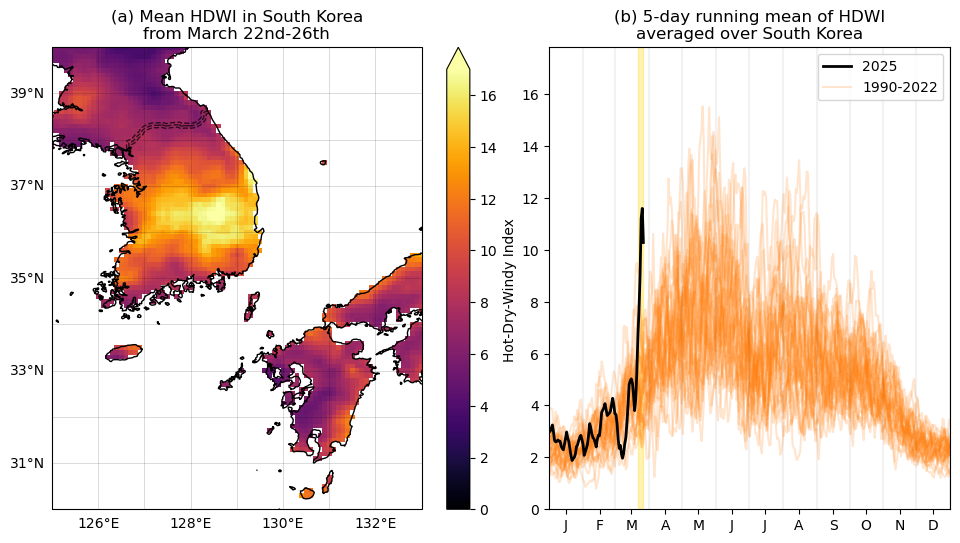

In [134]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6), dpi = 100, gridspec_kw = {"width_ratios" : [1.25,1]})
plt.subplots_adjust(wspace = 0.06)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
ev.plot(ax = map_ax, vmin = 0, vmax = 17, cmap = "inferno", cbar_kwargs = {"label" : "Hot-Dry-Windy Index", "location" : "right", "pad" : 0.05, "shrink" : 1})
# map_ax.scatter(px_m.longitude, px_m.latitude, color = "k", marker = ".")
# map_ax.scatter(sites.lon, sites.lat, color = "darkred", marker = "x")

map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', alpha = 0.2, xlocs = range(125,134), ylocs = range(30,42))
map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["left", "bottom"], alpha = 0, xlocs = range(124,134,2), ylocs = range(31,42,2))

map_ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
map_ax.coastlines()
map_ax.set_title("(a) Mean HDWI in South Korea\nfrom March 22nd-26th")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(122)

y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", lw = 2, zorder = 99)
for y in range(1990,2021):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:orange", alpha = 0.2, label = "_years")
    
# ts_ax.plot(ts.sel(time = slice("1990", "2021")).groupby("time.dayofyear").mean(), color = "darkred")
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)
[ts_ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

ts_ax.legend(["2025", "1990-2022"])
ylim = ts_ax.get_ylim()
d_start = ts.sel(time = "2025-03-22").time.dt.dayofyear.values
ts_ax.add_patch(Rectangle((d_start, 0), 5, ylim[1]+20, color = "gold", alpha = 0.3))
ts_ax.set_ylim(0,17.8)
ts_ax.margins(x = 0)

ts_ax.set_ylabel("")
ts_ax.set_title("(b) 5-day running mean of HDWI\naveraged over South Korea")
plt.savefig("fig/fig1-1_event-map-hdwi.png")

# 1.2 - precip

In [164]:
from xclim.indices.stats import fit
from scipy.stats import norm, gamma

pr = xr.open_dataset("data/era5land/pr-monthly_era5land_195001-202503.nc").pr
pr_fm = pr.sel(time = pr.time.dt.month.isin([2,3])).resample(time = "AS-FEB").sum()

pr_clim = pr_fm.sel(time = slice("1990","2020")).mean("time")
relanom = ((pr_fm.sel(time = "2025", drop = True) - pr_clim) / pr_clim * 100)

ts = xr.open_dataset("daily-ts/pr_era5_195001-202503_kr.nc").pr
ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 181).data))

days = pd.date_range(start = "2020-07-01", end = "2021-07-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

/var/tmp/pbs.1005679.pbs/ipykernel_993511/62799673.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))


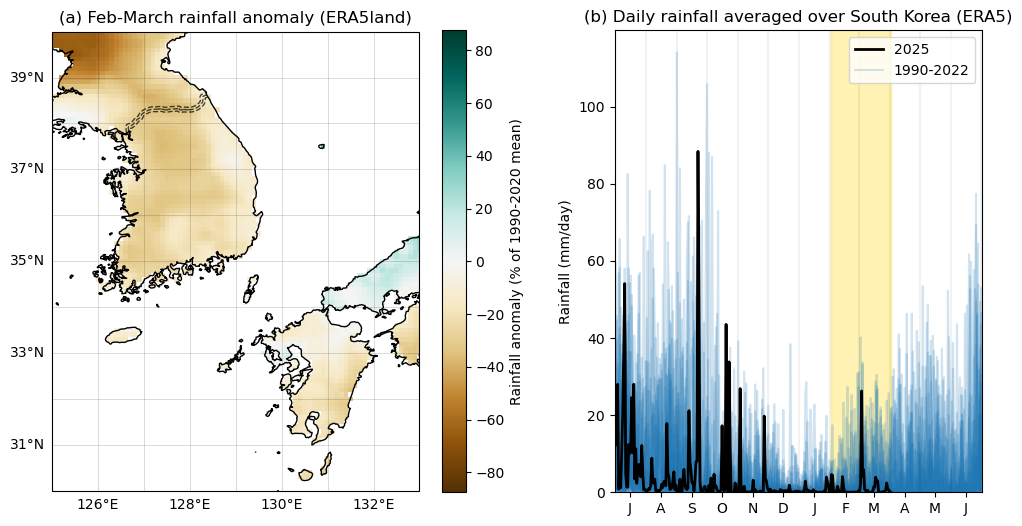

In [168]:
fig, axs = plt.subplots(ncols = 2, figsize = (12,6), dpi = 100, gridspec_kw = {"width_ratios" : [1.25,1]})
plt.subplots_adjust(wspace = 0.25)

map_ax =  plt.subplot(121, projection = mapproj, extent = (xn,xx,yn,yx))
relanom.plot(ax = map_ax, cmap = "BrBG", cbar_kwargs = {"label" : "Rainfall anomaly (% of 1990-2020 mean)", "location" : "right", "pad" : 0.05, "shrink" : 1})

map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', alpha = 0.2, xlocs = range(125,134), ylocs = range(30,42))
map_ax.gridlines(crs = mapproj, linewidth = 0.5, color = 'black', draw_labels = ["left", "bottom"], alpha = 0, xlocs = range(124,134,2), ylocs = range(31,42,2))

map_ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
map_ax.coastlines()
map_ax.set_title("(a) Feb-March rainfall anomaly (ERA5land)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts_ax =  plt.subplot(122)

y = 2024; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", lw = 2, zorder = 99)
for y in range(1990,2021):
    ts_y = ts.sel(time = ts.offset_time.dt.year == y)
    ts_ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.2, label = "_years")
    
ts_ax.set_xticks(labelticks)
ts_ax.set_xticklabels(labels)
[ts_ax.axvline(x, color = "k", alpha = 0.05) for x in range(366) if (days[x].day) == 1]

ts_ax.legend(["2025", "1990-2022"])
ylim = ts_ax.get_ylim()
d_start = ts.sel(time = "2025-01-31").offset_time.dt.dayofyear.values
ts_ax.add_patch(Rectangle((d_start, 0), 59, ylim[1]+20, color = "gold", alpha = 0.3))
ts_ax.set_ylim(0,ylim[1])
ts_ax.margins(x = 0)

ts_ax.set_ylabel("Rainfall (mm/day)")
ts_ax.set_title("(b) Daily rainfall averaged over South Korea (ERA5)")
plt.savefig("fig/fig1-2_event-map-pr-fm.png")

# 3.2 SC of components of the HDWI

In [14]:
vpd = xr.open_dataset("daily-ts/vpdmax_era5land_195001-202503_kr.nc").vpdmax
sfcWindmax = xr.open_dataset("daily-ts/sfcWindmax_era5land_195001-202503_kr.nc").sfcWindmax
tasmax = xr.open_dataset("daily-ts/tasmax_era5land_195001-202503_kr.nc").tasmax
hursmin = xr.open_dataset("daily-ts/hursmin_era5land_195001-202503_kr.nc").hursmin

In [21]:
vpd.sel(time = "2025-03").to_dataframe()

,vpdmax
time,
2025-03-01,0.826949
2025-03-02,0.623836
2025-03-03,0.496471
2025-03-04,0.298312
2025-03-05,0.496164
2025-03-06,0.748239
2025-03-07,0.883106
2025-03-08,0.769015
2025-03-09,1.182393


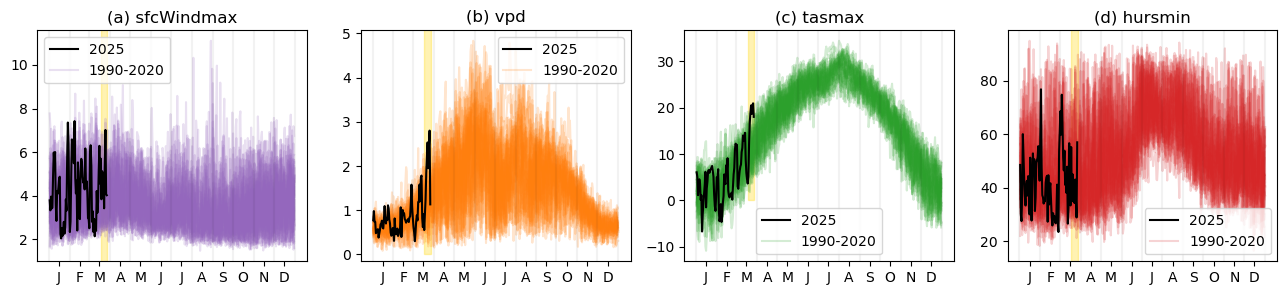

In [16]:
nc = 4; nr = 1
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.35)

days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

varbls = ["sfcWindmax", "vpd", "tasmax", "hursmin"]
colours = ["tab:purple", "tab:orange", "tab:green", "tab:red"]

for i in range(len(varbls)):
    ax = axs.flatten()[i]
    varnm = varbls[i]
    
    ts = eval(varnm)
    ts = ts.assign_coords(offset_time = ("time", ts.time.shift(time = 0).data)) # shift time for offset axes

    y = 2025; ts_y = ts.sel(time = ts.offset_time.dt.year == y); ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = "k", label = "2025", zorder = 99)
    
    for y in range(1990,2020):
        ts_y = ts.sel(time = ts.offset_time.dt.year == y)
        ax.plot(ts_y.offset_time.dt.dayofyear, ts_y, color = colours[i], alpha = 0.2, label = "_years")
    
    ax.set_title("("+"abcd"[i]+") "+varnm)
    
    ax.legend(["2025", "1990-2020"])
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((77, 0), 10, ylim[1]+10, color = "gold", alpha = 0.3))
    ax.set_ylim(ylim)
    
# plt.suptitle("Seasonal cycles of HDWI & component variables averaged over Korea (ERA5-land)", fontweight = "bold", y = 1.025)
plt.savefig("fig/fig3-2_sc-and-2025.png")

# A1.1 HDWI from vpdmax vs hursmin

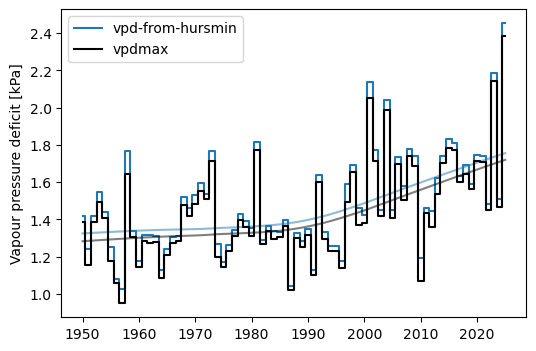

In [195]:
fig, ax = plt.subplots(ncols = 1, figsize = (6, 4), dpi = 100)
   
fl = [fnm for fnm in sorted(glob.glob("daily-ts/vpd*kr.nc")) if not "monthly" in fnm and not "dew" in fnm]

for fnm in fl:
    ts = xr.open_dataset(fnm)
    ts = ts[list(ts.data_vars)[0]]
    
    varnm = fnm.split("/")[-1].split("_")[0]
    col = {"vpdmax" : "k", "vpd-from-hursmin" : "tab:blue", "vpd-from-dewmax" : "tab:orange", "vpd-from-monthly" : "tab:green",
           "hdwi-from-vpdmax" : "k", "hdwi-from-hursmin" : "tab:blue", "hdwi-from-dewmax" : "tab:orange", "hdwi-from-monthly" : "tab:green"}[varnm]
    
    vpd5x = ts.rolling(time = 5).mean().groupby("time.month")[3].resample(time = "AS-MAR").max().dropna("time", "any")
    vpd5x = vpd5x.assign_coords(time = vpd5x.time.dt.year).rename(time = "year")
    
    vpd5x.plot(ax = ax, drawstyle = "steps-mid", label = varnm, color = col)
    ax.plot(vpd5x.year.values, lowess(vpd5x.values, vpd5x.year.values)[:,1], color = col, alpha = 0.5)
    
ax.legend()
ax.set_xlabel("")
plt.savefig("fig/app_compare-vpd-calculations.png")